# Test result of official YOLOv3

Source: https://pjreddie.com/darknet/yolo/

```
git clone https://github.com/pjreddie/darknet
cd darknet
make

wget https://pjreddie.com/media/files/yolov3.weights -P ./weights
./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

...
data/person.jpg: Predicted in 17.752988 seconds.
horse: 100%
dog: 99%
person: 100%

wget https://pjreddie.com/media/files/yolov3-tiny.weights -P ./weights
./darknet detect cfg/yolov3-tiny.cfg yolov3-tiny.weights data/person.jpg

...
data/person.jpg: Predicted in 0.703893 seconds.
horse: 94%
dog: 91%
dog: 90%
person: 86%
```

# YOLO Webcam on CPU

Source: https://pysource.com/2019/07/08/yolo-real-time-detection-on-cpu/

In [1]:
import cv2
import numpy as np
import time

# Load Yolo
net = cv2.dnn.readNet("/home/chanho/catkin_ws/models/darknet/weights/yolov3-tiny.weights", "/home/chanho/catkin_ws/models/darknet/cfg/yolov3-tiny.cfg")
classes = []
with open("/home/chanho/catkin_ws/models/darknet/data/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [2]:
# Loading camera
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_PLAIN
starting_time = time.time()
frame_id = 0

In [3]:
while True:
    _, frame = cap.read()
    frame_id += 1
    
    height, width, channels = frame.shape
    # Detecting objects
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    # Showing informations on the screen
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.1:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.4, 0.3)
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            color = colors[class_ids[i]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.rectangle(frame, (x, y), (x + w, y + 30), color, -1)
            cv2.putText(frame, label + " " + str(round(confidence, 2)), (x, y + 30), font, 3, (255,255,255), 3)
    elapsed_time = time.time() - starting_time
    fps = frame_id / elapsed_time
    cv2.putText(frame, "FPS: " + str(round(fps, 2)), (10, 50), font, 3, (0, 0, 0), 3)
    cv2.imshow("Image", frame)
    key = cv2.waitKey(1)
    if key == 27:
        break

In [4]:
cap.release()
cv2.destroyAllWindows()

# Result

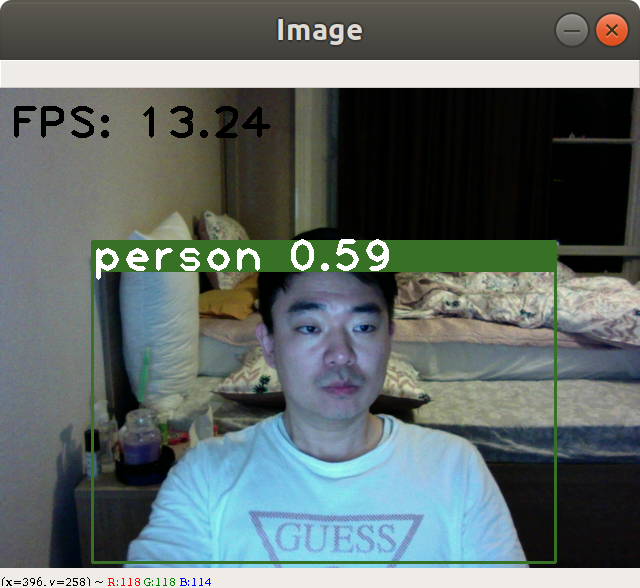

In [6]:
from IPython.display import display, Image
display(Image(filename='img/YOLOv3-tiny.png'))